In [23]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from sklearn.decomposition import FastICA
from sklearn.preprocessing import StandardScaler
from preprocessing_mne import stack_epochs, get_group_epochs, get_raw_subject_data

In [24]:
def create_sliding_windows(data, labels, window_length):
    """
    Splits each epoch in each array in 'data' into overlapping windows using a sliding window approach,
    and replicates the corresponding label for each new window.
    
    Parameters:
        data (list of np.ndarray): Each element has shape (n_epochs, n_channels, n_times).
                                   Note that n_epochs and n_times may differ between arrays.
        labels (list or np.ndarray): A list of labels corresponding to each array in data.
                                     (Each array's epochs are all assigned the same label.)
        window_length (int): Number of observations (time points) per window.
        
    Returns:
        windows (np.ndarray): Array with shape 
            (total_new_samples, n_channels, window_length),
            where total_new_samples is the sum over arrays of (n_epochs * (n_times - window_length + 1)).
        new_labels (np.ndarray): 1D array of labels of length total_new_samples.
            For each epoch, the first (n_windows // 5) and the last (n_windows // 8) windows get label 0,
            and the middle windows get the original label.
    """
    windows_all = []
    new_labels = []
    # Iterate over each array in data and its corresponding label.
    for X, label in zip(data, labels):
        # X has shape (n_epochs, n_channels, n_times)
        # Create sliding windows along the time axis.
        # This returns an array of shape (n_epochs, n_channels, n_windows, window_length),
        # where n_windows = n_times - window_length + 1.
        windows = np.lib.stride_tricks.sliding_window_view(X, window_length, axis=2)
        
        # Transpose to get shape: (n_epochs, n_windows, n_channels, window_length)
        windows = windows.transpose(0, 2, 1, 3)
        
        # Get dimensions for the current array.
        n_epochs, n_windows, n_channels, _ = windows.shape
        
        # Reshape windows so each sliding window becomes an independent sample:
        # New shape: (n_epochs * n_windows, n_channels, window_length)
        windows_reshaped = windows.reshape(n_epochs * n_windows, n_channels, window_length)
        windows_all.append(windows_reshaped)
        
        # Compute cutoff indices for the current array.
        # These determine how many windows at the beginning and end get assigned a label of 0.
        start_cut = n_windows // 5
        end_cut = n_windows // 8
        
        # For each epoch in the current array, create a label vector for its windows.
        for i in label:
            new_labels.extend([0] * start_cut + [i] * (n_windows - start_cut - end_cut) + [0] * (end_cut))
        
    # Concatenate windows from all arrays into a single array.
    windows_all = np.concatenate(windows_all, axis=0)
    new_labels = np.array(new_labels)  # This is a 1D array.
    
    return windows_all.astype(np.float32), new_labels

Reading 0 ... 23006  =      0.000 ...  2944.768 secs...


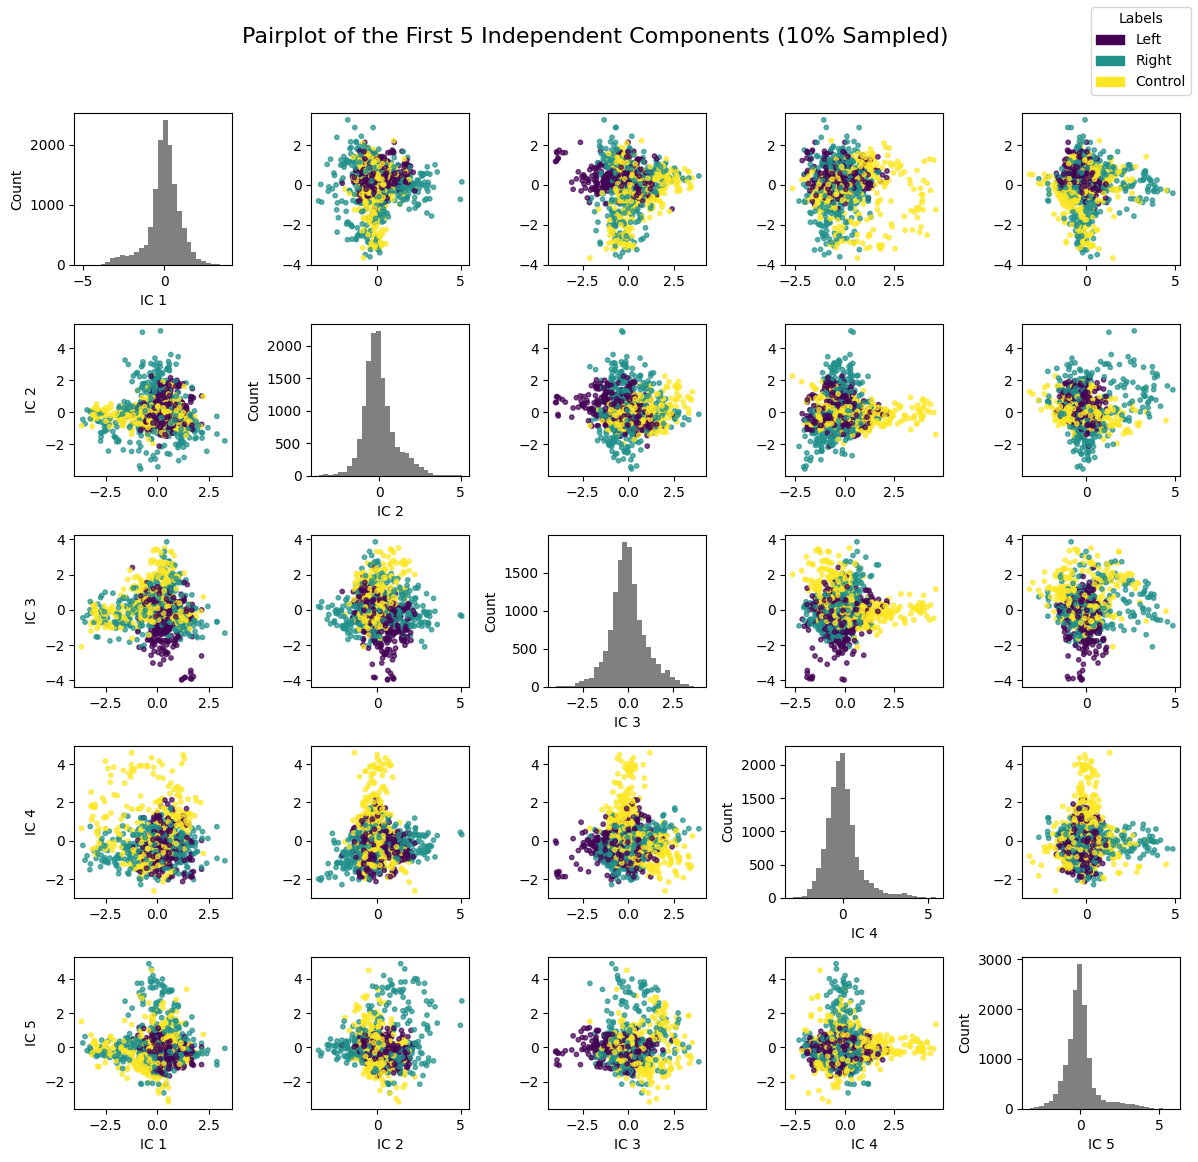

In [27]:
def visualize_ica_components(subject=0, window_length=1, nr_components=3):
    """
    Computes ICA for stacked epochs and visualizes the independent components.

    Args:
        subject (int): Subject number to analyze. Default is 0.
        window_length (float): Window length in seconds for epoch segmentation. Default is 1.
        nr_components (int): Number of independent components to extract and visualize. Default is 3.

    Returns:
        tuple: (fig, X_ica, ica_model) - The figure object, ICA-transformed data, and the ICA object.
    """
    # # Extract subject-specific epochs and stack them into features and labels.
    # epochs = get_group_epochs(add_hbr=False, hbr_multiplier=5.0, hbr_shift=1.0,
    #                           tmin=-5, tmax=15, force_download=False)

    # data = []
    # for i in range(len(epochs)):
    #     data.append(epochs[i].copy().crop(tmin=0, tmax=14).get_data())

    # # Normalize each array across channels.
    # for X in data:
    #     n_epochs, n_channels, n_times = X.shape
    #     for ch in range(n_channels):
    #         channel_mean = np.mean(X[:, ch, :])
    #         channel_std = np.std(X[:, ch, :])
    #         X[:, ch, :] = (X[:, ch, :] - channel_mean) / channel_std

    # # Create labels (subtract one to have classes 0,1,2).
    # labels = [epoch.events[:, -1].astype(np.int64) - 1 for epoch in epochs]

    # # Split data: select test subject X_test and corresponding labels y_test.
    # X_train, X_test, y_train, y_test =  data[:subject] + data[subject+1:], data[subject], \
    #                                     labels[:subject] + labels[subject+1:], labels[subject]
    
    # # Create sliding windows for the test subject data.
    # X_train_np, y_train_np = create_sliding_windows([X_test], [y_test], window_length=window_length)
    # print("X_train_np shape:", X_train_np.shape)  # Expect shape (n_samples, n_channels, window_length)

    # # Flatten each sliding window (n_channels x window_length) into a feature vector.
    # X_flat = X_train_np.reshape(X_train_np.shape[0], -1)

    X = get_raw_subject_data(subject)

    control = X['Control']
    left = X['Tapping_Left']
    right = X['Tapping_Right']

    # Find the activity with min amount of epochs
    min_bound = np.min([x.get_data().shape[0] for x in [control, left, right]])

    # Reshape function
    def reshape_activity(epoch, min_bound):
        """Limit epochs to min bound, reshape data to channels x merged_epochs"""
        epoch_data = epoch.get_data()[:min_bound, :, :]
        # epoch_data = epoch.get_data()
        n_epoch, n_channels, n_epoch_size = epoch_data.shape
        epoch_data_reshaped = epoch_data.reshape(n_channels, n_epoch * n_epoch_size)
        return epoch_data_reshaped.T

    # Reshape all activities
    control_reshaped = reshape_activity(control, min_bound)
    left_reshaped = reshape_activity(left, min_bound)
    right_reshaped = reshape_activity(right, min_bound)

    # Define input matrix
    X = np.concatenate([control_reshaped, left_reshaped, right_reshaped], axis=0)

    # Compute ICA on the flattened windows.
    ica_model = FastICA(n_components=nr_components, tol=0.0001, random_state=42)
    X_ica = ica_model.fit_transform(X)

    length = control_reshaped.shape[0]
    y = np.concatenate([np.full(length, 1), np.full(length, 2), np.full(length, 3)])
    
    # Determine random indices for 10% of the data.
    n_samples = X_ica.shape[0]
    sample_size = max(1, int(0.1 * n_samples))
    random_indices = np.random.choice(n_samples, size=sample_size, replace=False)

    # Create a grid of plots for the independent components.
    fig, axes = plt.subplots(nr_components, nr_components, figsize=(12, 12))
    components = [f'IC {i+1}' for i in range(nr_components)]

    for i in range(nr_components):
        for j in range(nr_components):
            ax = axes[i, j]
            if i == j:
                # Diagonal: Histogram of the component values.
                ax.hist(X_ica[:, i], bins=30, color='gray')
                ax.set_xlabel(components[i])
                ax.set_ylabel('Count')
            else:
                # Off-diagonals: Scatter plot of two components using 10% of the data.
                sc = ax.scatter(X_ica[random_indices, j], X_ica[random_indices, i],
                                c=y[random_indices], cmap='viridis', alpha=0.7, s=10)
                if i == nr_components - 1:
                    ax.set_xlabel(components[j])
                if j == 0:
                    ax.set_ylabel(components[i])

    plt.suptitle(f'Pairplot of the First {nr_components} Independent Components (10% Sampled)', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Add a legend indicating which label is Left, Right, and Control.
    # Assuming labels 0, 1, 2 correspond to Left, Right, and Control respectively.

    norm = plt.Normalize(vmin=0, vmax=2)
    cmap = plt.cm.viridis
    colors_used = {l: cmap(norm(l)) for l in range(3)}
    label_mapping = {0: 'Left', 1: 'Right', 2: 'Control'}
    patches = [mpatches.Patch(color=colors_used[l], label=label_mapping[l]) for l in range(3)]
    fig.legend(handles=patches, loc='upper right', title="Labels")
    
    return fig, X_ica, ica_model

fig, X_ica, ica_model = visualize_ica_components(subject=4, window_length=1, nr_components=5)
plt.show()

In [ ]:
import numpy as np
from sklearn.decomposition import FastICA
from scipy.spatial import procrustes

def compute_ica_components_for_subject(data, window_length, nr_components):
    """
    Computes ICA on sliding windows for a single subject's data.
    
    Args:
        data (np.ndarray): Raw data of shape (n_epochs, n_channels, n_times)
        window_length (int): Length of each sliding window.
        nr_components (int): Number of ICA components.
    
    Returns:
        X_ica (np.ndarray): ICA-transformed data.
        ica_model (FastICA): The fitted ICA model.
    """
    X_windows, _ = create_sliding_windows([data], [np.array([1])], window_length=window_length)
    X_flat = X_windows.reshape(X_windows.shape[0], -1)
    ica_model = FastICA(n_components=nr_components, random_state=42)
    X_ica = ica_model.fit_transform(X_flat)
    return X_ica, ica_model

def align_ica_components_across_subjects(subject_data_list, window_length=10, nr_components=5):
    """
    Computes ICA for each subject and aligns the ICA components using Procrustes analysis.
    Before alignment, randomly sample the same number of rows across subjects.
    
    Args:
        subject_data_list (list): List of raw data arrays (n_epochs, n_channels, n_times)
                                  for each subject.
        window_length (int): Window length for sliding windows.
        nr_components (int): Number of ICA components.
    
    Returns:
        aligned_components_list (list): List of aligned ICA components for each subject.
        ica_models_list (list): List of corresponding FastICA objects.
    """
    ica_models_list = []
    ica_components_list = []
    
    # Compute ICA for each subject.
    for data in subject_data_list:
        X_ica, ica_model = compute_ica_components_for_subject(data, window_length, nr_components)
        ica_components_list.append(X_ica)
        ica_models_list.append(ica_model)
    
    # Determine the minimum number of samples across subjects.
    min_samples = min(ica.shape[0] for ica in ica_components_list)
    # Randomly sample min_samples rows from each subject's ICA components.
    ica_components_list_sampled = []
    for X_ica in ica_components_list:
        if X_ica.shape[0] > min_samples:
            indices = np.random.choice(X_ica.shape[0], size=min_samples, replace=False)
            X_sampled = X_ica[indices]
        else:
            X_sampled = X_ica
        ica_components_list_sampled.append(X_sampled)
    
    # Use the first subject's sampled ICA components as reference.
    ref = ica_components_list_sampled[4]
    aligned_components_list = [ref]
    
    # Align each subsequent subject's ICA components to the reference.
    for X_ica in ica_components_list_sampled[1:]:
        _, aligned, _ = procrustes(ref, X_ica)
        aligned_components_list.append(aligned)
        
    return aligned_components_list, ica_models_list

# --- Example Usage ---

# 1. Load group epochs and build a list of raw data for each subject.
epochs = get_group_epochs(add_hbr=False, hbr_multiplier=5.0, hbr_shift=1.0,
                          tmin=-5, tmax=15, force_download=False)
subject_data_list = []

for epoch in epochs:
    data = epoch.copy().crop(tmin=0, tmax=14).get_data()
    n_epochs, n_channels, n_times = data.shape
    for ch in range(n_channels):
        channel_mean = np.mean(data[:, ch, :])
        channel_std = np.std(data[:, ch, :])
        data[:, ch, :] = (data[:, ch, :] - channel_mean) / channel_std
    subject_data_list.append(data)

# 2. Define window length and desired number of ICA components.
window_length = 10
nr_components = 5

# 3. Compute and align ICA components across all subjects.
aligned_components, ica_models = align_ica_components_across_subjects(subject_data_list, window_length, nr_components)

# 4. Plot an example: aligned ICA components for the first subject.
fig, axes = plt.subplots(nr_components, nr_components, figsize=(12, 12))
components = [f'IC {i+1}' for i in range(nr_components)]
X_ica_sample = aligned_components[0]
n_samples = X_ica_sample.shape[0]
sample_size = max(1, int(0.1 * n_samples))
random_indices = np.random.choice(n_samples, size=sample_size, replace=False)

for i in range(nr_components):
    for j in range(nr_components):
        ax = axes[i, j]
        if i == j:
            ax.hist(X_ica_sample[:, i], bins=30, color='gray')
            ax.set_xlabel(components[i])
            ax.set_ylabel('Count')
        else:
            ax.scatter(X_ica_sample[random_indices, j], X_ica_sample[random_indices, i],
                       cmap='viridis', alpha=0.7, s=10)
            if i == nr_components - 1:
                ax.set_xlabel(components[j])
            if j == 0:
                ax.set_ylabel(components[i])
                
plt.suptitle('Aligned ICA Components for Subject 1 (10% Sampled)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.show()

Reading 0 ... 23238  =      0.000 ...  2974.464 secs...


UnboundLocalError: cannot access local variable 'epochs' where it is not associated with a value

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

def run_aligned_classifier(test_subject=0, window_length=10, nr_components=5):
    """
    For each subject, this function creates sliding windows and computes ICA features.
    It then randomly samples a common number of rows from each subject’s ICA features and
    aligns them using Procrustes analysis. Finally, it trains an MLP classifier on the
    training subjects' aligned features and evaluates on the test subject.
    
    Args:
        test_subject (int): Index of the subject to use for testing.
        window_length (int): Length (in time points) of each sliding window.
        nr_components (int): Number of ICA components.
    
    Returns:
        clf: Trained classifier.
        acc: Test accuracy.
        y_test: True labels of the test subject.
        y_pred: Predicted labels on the test subject.
    """
    # Load group epochs and build raw data & label lists for each subject.
    epochs = get_group_epochs(add_hbr=False, hbr_multiplier=5.0, hbr_shift=1.0,
                              tmin=-5, tmax=15, force_download=False)
    raw_list = []
    label_list = []
    for epoch in epochs:
        # Extract raw data and crop.
        X = epoch.copy().crop(tmin=0, tmax=14).get_data()
        # Normalize each channel.
        n_epochs, n_channels, n_times = X.shape
        for ch in range(n_channels):
            channel_mean = np.mean(X[:, ch, :])
            channel_std = np.std(X[:, ch, :])
            X[:, ch, :] = (X[:, ch, :] - channel_mean) / channel_std
        raw_list.append(X)
        # Create labels (subtract one so classes become 0,1,2)
        label_list.append(epoch.events[:, -1].astype(np.int64) - 1)
    
    # Compute sliding windows, flatten and ICA for each subject.
    subjects_features = []  # List of ICA features per subject.
    subjects_labels   = []  # Corresponding label vectors.
    for X, lab in zip(raw_list, label_list):
        X_wins, y_wins = create_sliding_windows([X], [lab], window_length=window_length)
        X_flat = X_wins.reshape(X_wins.shape[0], -1)
        ica_model = FastICA(n_components=nr_components, random_state=41, whiten='unit-variance') #NOTE: Whiten should be "unit-variance"
        X_ica = ica_model.fit_transform(X_flat)
        X_ica = X_ica[:, [0,2]] #NOTE: Selecting only components 2 and 3
        subjects_features.append(X_ica)
        subjects_labels.append(y_wins)
        
    
    # Determine the common number of rows (samples) across subjects.
    min_samples = min(feat.shape[0] for feat in subjects_features)
    sampled_features = []
    sampled_labels = []
    for X_ica, y in zip(subjects_features, subjects_labels):
        if X_ica.shape[0] > min_samples:
            indices = np.random.choice(X_ica.shape[0], size=min_samples, replace=False)
            X_sample = X_ica[indices]
            y_sample = y[indices]
        else:
            X_sample = X_ica
            y_sample = y
        sampled_features.append(X_sample)
        sampled_labels.append(y_sample)
    
    # Choose a reference for alignment.
    # Use the first training subject as reference (if test_subject==0, then use subject1)
    ref_index = 0 if test_subject != 0 else 1
    ref = sampled_features[ref_index]
    
    # Align each subject's ICA features to the reference using Procrustes.
    aligned_features = []
    for feat in sampled_features:
        # If already the reference, leave unchanged.
        if np.array_equal(feat, ref):
            aligned_features.append(feat)
        else:
            # Procrustes returns (d, aligned, disparity)
            _, aligned, _ = procrustes(ref, feat)
            aligned_features.append(aligned)
    
    # Split into training and test sets.
    X_test = aligned_features[test_subject]
    y_test = sampled_labels[test_subject]
    
    # Aggregate training subjects (all subjects except test_subject).
    X_train = np.concatenate([aligned_features[i] for i in range(len(aligned_features)) if i != test_subject], axis=0)
    y_train = np.concatenate([sampled_labels[i] for i in range(len(sampled_labels)) if i != test_subject], axis=0)
    
    # Train an MLP classifier on the training data.
    clf = MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, random_state=42)
    clf.fit(X_train, y_train)
    
    # Predict on the test data.
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print("Test subject:", test_subject)
    print("Test accuracy: {:.2f}%".format(acc * 100))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    
    return clf, acc, y_test, y_pred

# Run the aligned classifier on subject 1 (adjust test_subject index as needed)
clf, acc, y_test, y_pred = run_aligned_classifier(test_subject=1, window_length=10, nr_components=5)

Reading 0 ... 23238  =      0.000 ...  2974.464 secs...


Used Annotations descriptions: ['Control', 'Tapping_Left', 'Tapping_Right']
Reading 0 ... 18877  =      0.000 ...  2416.256 secs...
Used Annotations descriptions: ['Control', 'Tapping_Left', 'Tapping_Right']
Reading 0 ... 18874  =      0.000 ...  2415.872 secs...
Used Annotations descriptions: ['Control', 'Tapping_Left', 'Tapping_Right']
Reading 0 ... 23120  =      0.000 ...  2959.360 secs...
Used Annotations descriptions: ['Control', 'Tapping_Left', 'Tapping_Right']
Reading 0 ... 23006  =      0.000 ...  2944.768 secs...
Used Annotations descriptions: ['Control', 'Tapping_Left', 'Tapping_Right']


c:\Users\oscar\anaconda3\envs\venv\Lib\site-packages\sklearn\decomposition\_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Test subject: 1
Test accuracy: 65.05%
Confusion Matrix:
 [[2825    0    0]
 [ 966    0    0]
 [ 552    0    0]]
